# www.epolicija.lt atvirų duomenų analizė

Data: ~2019-12-03~

Autorius: © 2019 ~Martynas Pocius, https://github.com/martasp. 

## Analizė atsako į šiuos klausimus:
1. ~[Pirmas MP1 klausimas](#Pirmas-MP1-klausimas?)~?
1. ~[Antras MP1 klausimas](#Antras-MP1-klausimas?)~?
1. ~[Trečias MP1 klausimas](#Trečias-MP1-klausimas?)~? (MM)
1. ~[Pirmas MP2 klausimas](#Pirmas-MP2-klausimas?)~? (MM2)
1. ~[Antras MP2 klausimas](#Pirmas-MP2-klausimas?)~? (MM2)
1. ~[Trečias MP2 klausimas](#Trečias-MP2-klausimas?)~? (MM2)

## Pasitelkiami duomenų šaltiniai:
* ~[https://www.epolicija.lt/atviri-duomenys](https://www.epolicija.lt/atviri-duomenys)~

Šis sąsiuvinis yra platinamas pagal <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Priskyrimas 4.0 Tarptautinė licenciją</a>. <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons licencija" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a> 

Jis yra dalis atsiskaitymo [KTU IF](https://if.ktu.edu/) kurse [P176M010 "Pažangus mašininis mokymasis"](https://stojantiesiems.ktu.edu/programme/m-programu-sistemu-inzinerija/#P176M010), kurį veda [M. Lukoševičius](http://mantas.info/).

## Įsikeliame duomenis

In [231]:
import numpy as np
import pandas as pd, io, requests
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
plt.style.use('classic')
%matplotlib inline
# import seaborn as sns
import io, requests

df = pd.read_excel('https://www.epolicija.lt/c/document_library/get_file?uuid=39221a0e-c0aa-406c-82df-0d87535c1b49&groupId=10156.csv', sheet_name='workshop_register(6)')
df = pd.read_excel('data.xls', sheet_name='workshop_register(8)')




## ~Avarijų skaičiaus priklausomybė nuo dienos laiko.~? 

Text(0, 0.5, 'Avarijų skaičius (kiekis)')

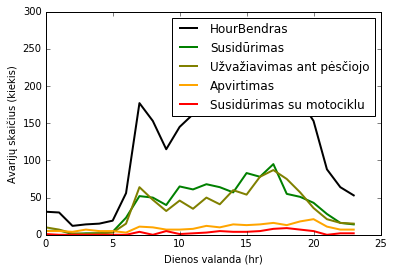

In [232]:
df1 = df[['Savivaldybė','Data','Laikas','Žuvusių skaičius','Įvykio rūšis','Ar asmuo kaltas dėl eismo įvykio (1 - taip, 0 - ne)']]
df1 = df1[df['Įvykio rūšis'].notnull()]
events = df1[['Įvykio rūšis','Laikas']][df1['Įvykio rūšis'].notnull()]
events['Hour'] = events['Laikas'].apply(lambda x: x.hour)
eventBin = events.groupby(['Hour'])['Įvykio rūšis'].count().to_frame('Count').reset_index()
other = events.groupby(['Įvykio rūšis','Hour'])['Hour'].count().to_frame('Count').reset_index()
piv = other.pivot(index='Hour' ,columns='Įvykio rūšis',values='Count')
piv = piv.replace(np.nan, 0).reset_index().rename_axis(None, axis=1)
piv['HourBendras'] = eventBin['Count']
piv
plt.plot( 'Hour', 'HourBendras', data=piv, marker='', color='Black', linewidth=2)
plt.plot( 'Hour', 'Susidūrimas', data=piv, marker='', color='green', linewidth=2)
plt.plot( 'Hour', 'Užvažiavimas ant pėsčiojo', data=piv, marker='', color='olive', linewidth=2)
plt.plot( 'Hour', 'Apvirtimas', data=piv, marker='', color='orange', linewidth=2)
plt.plot( 'Hour', 'Susidūrimas su motociklu', data=piv, marker='', color='red', linewidth=2)
plt.legend()
plt.xlabel('Dienos valanda (hr)')
plt.ylabel('Avarijų skaičius (kiekis)')

## ~Žuvusiųjų skaičiaus pasiskirstymas nuo dangos tipo?~?

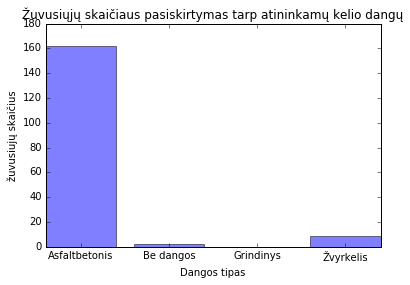

In [233]:
df1 = df[['Dangos rūšis','Žuvusių skaičius']]
df1 = df1[df['Dangos rūšis'].notnull()]
grouped = df1.groupby(['Dangos rūšis'])['Žuvusių skaičius'].sum().to_frame('sum').reset_index()
grouped
plt.bar(grouped['Dangos rūšis'],grouped['sum'] , align='center', alpha=0.5)
plt.xticks((0,1,2,3),('Asfaltbetonis','Be dangos','Grindinys','Žvyrkelis'))
plt.ylabel('žuvusiujų skaičius')
plt.xlabel('Dangos tipas')
plt.title('Žuvusiųjų skaičiaus pasiskirtymas tarp atininkamų kelio dangų')
plt.show()

## ~Vairuotjų stažo priklausomybė nuo kaltumo~?
Sudaroma analitinė funkcija kaip vairuotoju stažas priklauso nuo incidento kaltumo kiekio kur x yra vairavimo stažas o y kaltu kiekis. Su šia funkcija galime prognuozuoti kiek vidutiniskai per metus bus kaltų žmoniu su tam tikru stažu.

C:\Users\mart\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


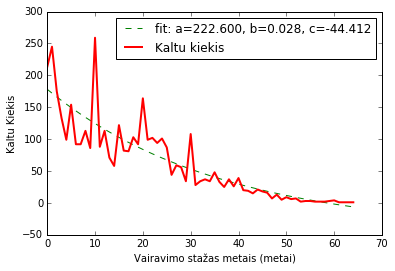

In [234]:
df1 = df[['Vairavimo stažas metais','Ar asmuo kaltas dėl eismo įvykio (1 - taip, 0 - ne)']]
df1 = df1[df1['Vairavimo stažas metais'].notnull()]
grouped1 = df1.groupby(['Vairavimo stažas metais'])['Ar asmuo kaltas dėl eismo įvykio (1 - taip, 0 - ne)'].count().to_frame('count').reset_index()
grouped1['KaltuKiekis'] = grouped1['count'] 

# soruce : https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
from scipy.optimize import curve_fit
def func(x, a, b, c): return a * np.exp(-b * x) + c
popt, pcov = curve_fit(func,  grouped1['Vairavimo stažas metais'],  grouped1['KaltuKiekis'])
plt.plot(grouped1['Vairavimo stažas metais'], func(grouped1['Vairavimo stažas metais'],*popt), 'g--', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.plot('Vairavimo stažas metais', 'KaltuKiekis', label='Kaltu kiekis', data=grouped1, marker='', color='red', linewidth=2)
plt.xlabel('Vairavimo stažas metais (metai)')
plt.ylabel('Kaltu Kiekis')
plt.legend()
plt.show()


## Pirmas MP2 klausimas: Kas labiausiai lemia eismo įvykio žutį?

,"Neįgalumas (1 - taip, 0 - ne)",Lytis_Moteris,Lytis_Vyras,Saugos diržo naudojimas_Neužsegtas,Saugos diržo naudojimas_Neįrengtas,Saugos diržo naudojimas_Užsegtas
3169,0.0,1,0,0,0,0
10370,0.0,1,0,0,0,1
6864,0.0,0,1,0,0,1
13408,0.0,1,0,0,0,1
5166,0.0,0,1,0,0,1
...,...,...,...,...,...,...
10449,0.0,0,1,0,0,1
6890,0.0,0,1,0,0,1
3447,0.0,0,1,0,0,1
5464,0.0,0,1,0,0,0


Number of Trees used :  500

Target on train data [0 0 0 ... 0 0 0]

accuracy_score on train dataset :  0.9794871794871794

Target on test data [0 0 0 ... 0 0 0]

accuracy_score on test dataset :  0.9772893772893773


Text(0.5, 0, 'Relative Importance')

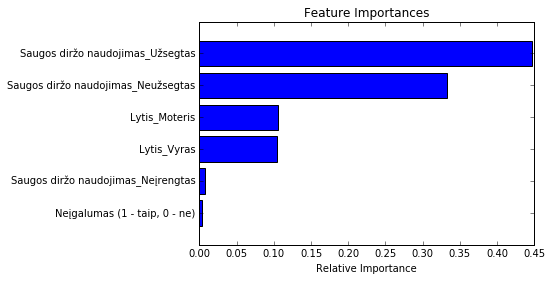

In [247]:
# Kas labiausiai lemia eismo įvykio vairuotojo žutį
# # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
df = pd.read_excel('https://www.epolicija.lt/c/document_library/get_file?uuid=39221a0e-c0aa-406c-82df-0d87535c1b49&groupId=10156.csv', sheet_name='workshop_register(6)')
df = pd.read_excel('data.xls', sheet_name='workshop_register(8)')
data = df[['Lytis','Neįgalumas (1 - taip, 0 - ne)','Saugos diržo naudojimas','Eismo įvykio dalyvio būklė']]
data = data[data['Eismo įvykio dalyvio būklė'].notnull()]
data[data==np.inf]=np.nan
data.fillna(data.mean(), inplace=True) # clean data
data = pd.get_dummies(data) # duomenu normalizavimas


dataWithout = data.drop(columns=['Eismo įvykio dalyvio būklė_Žuvo','Eismo įvykio dalyvio būklė_Mirė nuo sužalojimų','Eismo įvykio dalyvio būklė_Nenukentėjo','Eismo įvykio dalyvio būklė_Sužeistas'])
train_x, test_x, train_y, test_y = train_test_split(dataWithout,data['Eismo įvykio dalyvio būklė_Žuvo'], test_size = 0.2, random_state = 0)
display(train_x)

model = RandomForestClassifier(n_estimators=500)
# fit the model with the training data
model.fit(train_x,train_y)
# number of trees used
print('Number of Trees used : ', model.n_estimators)
# predict the target on the train dataset
predict_train = model.predict(train_x)
print('\nTarget on train data',predict_train) 
# Accuray Score on train dataset
accuracy_train = accuracy_score(train_y,predict_train)
print('\naccuracy_score on train dataset : ', accuracy_train)
# predict the target on the test dataset
predict_test = model.predict(test_x)
print('\nTarget on test data',predict_test) 
# Accuracy Score on test dataset
accuracy_test = accuracy_score(test_y,predict_test)
print('\naccuracy_score on test dataset : ', accuracy_test)

importances = model.feature_importances_
indices = np.argsort(importances)
features = train_x.columns.values
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

# print(model.predict([[0,0,0,0,0,0,0,0,1]]))

## ~Trečias MP2 klausimas~ Kokie veiksniai labiausiai įtakoja nenukentėjusį asmenį eismo įvykyje?

,"Neįgalumas (1 - taip, 0 - ne)",Lytis_Moteris,Lytis_Vyras,Saugos diržo naudojimas_Neužsegtas,Saugos diržo naudojimas_Neįrengtas,Saugos diržo naudojimas_Užsegtas
3169,0.0,1,0,0,0,0
10370,0.0,1,0,0,0,1
6864,0.0,0,1,0,0,1
13408,0.0,1,0,0,0,1
5166,0.0,0,1,0,0,1
...,...,...,...,...,...,...
10449,0.0,0,1,0,0,1
6890,0.0,0,1,0,0,1
3447,0.0,0,1,0,0,1
5464,0.0,0,1,0,0,0


Number of Trees used :  500

Target on train data [0 1 1 ... 1 0 1]

accuracy_score on train dataset :  0.7036630036630037

Target on test data [0 1 0 ... 0 1 0]

accuracy_score on test dataset :  0.676923076923077
[]


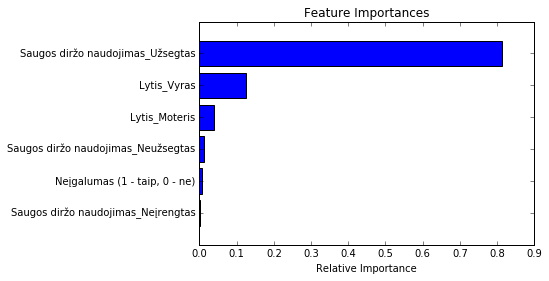

In [245]:
# Kokie veiksniai labiausiai įtakoja nenukentėjusį asmenį eismo įvykyje ?
# # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import GradientBoostingClassifier

data = df[['Lytis','Neįgalumas (1 - taip, 0 - ne)','Saugos diržo naudojimas','Eismo įvykio dalyvio būklė']]
data = data[data['Eismo įvykio dalyvio būklė'].notnull()]
data[data==np.inf]=np.nan
data.fillna(data.mean(), inplace=True) # clean data
data = pd.get_dummies(data) # duomenu normalizavimas


dataWithout = data.drop(columns=['Eismo įvykio dalyvio būklė_Žuvo','Eismo įvykio dalyvio būklė_Mirė nuo sužalojimų','Eismo įvykio dalyvio būklė_Nenukentėjo','Eismo įvykio dalyvio būklė_Sužeistas'])
train_x, test_x, train_y, test_y = train_test_split(dataWithout,data['Eismo įvykio dalyvio būklė_Nenukentėjo'], test_size = 0.2, random_state = 0)
display(train_x)

model = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,max_depth=50, random_state=0)

# fit the model with the training data
model.fit(train_x,train_y)
# number of estimators used
print('Number of Trees used : ', model.n_estimators)
# predict the target on the train dataset
predict_train = model.predict(train_x)
print('\nTarget on train data',predict_train) 
# Accuray Score on train dataset
accuracy_train = accuracy_score(train_y,predict_train)
print('\naccuracy_score on train dataset : ', accuracy_train)
# predict the target on the test dataset
predict_test = model.predict(test_x)
print('\nTarget on test data',predict_test) 
# Accuracy Score on test dataset
accuracy_test = accuracy_score(test_y,predict_test)
print('\naccuracy_score on test dataset : ', accuracy_test)

importances = model.feature_importances_
indices = np.argsort(importances)
features = train_x.columns.values
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')


print(dd)
# print(model.predict([[0,0,0,0,0,0,0,0,1]]))

## ~Trečias MP2 klausimas~ Kokie veiksniai labiausiai įtakoja sužeistą asmenį eismo įvykyje ?

,"Neįgalumas (1 - taip, 0 - ne)",Lytis_Moteris,Lytis_Vyras,Saugos diržo naudojimas_Neužsegtas,Saugos diržo naudojimas_Neįrengtas,Saugos diržo naudojimas_Užsegtas
3169,0.0,1,0,0,0,0
10370,0.0,1,0,0,0,1
6864,0.0,0,1,0,0,1
13408,0.0,1,0,0,0,1
5166,0.0,0,1,0,0,1
...,...,...,...,...,...,...
10449,0.0,0,1,0,0,1
6890,0.0,0,1,0,0,1
3447,0.0,0,1,0,0,1
5464,0.0,0,1,0,0,0


Number of Trees used :  1000

Target on train data [1 0 0 ... 0 1 0]

accuracy_score on train dataset :  0.689010989010989

Target on test data [1 0 1 ... 0 0 0]

accuracy_score on test dataset :  0.6754578754578755


Text(0.5, 0, 'Relative Importance')

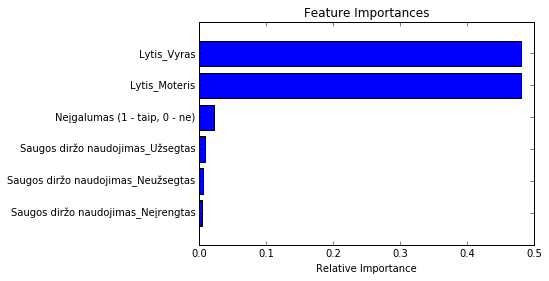

In [243]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
# # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
data = df[['Lytis','Neįgalumas (1 - taip, 0 - ne)','Saugos diržo naudojimas','Eismo įvykio dalyvio būklė']]
data = data[data['Eismo įvykio dalyvio būklė'].notnull()]
data[data==np.inf]=np.nan
data.fillna(data.mean(), inplace=True) # clean data
data = pd.get_dummies(data) # duomenu normalizavimas


dataWithout = data.drop(columns=['Eismo įvykio dalyvio būklė_Žuvo','Eismo įvykio dalyvio būklė_Mirė nuo sužalojimų','Eismo įvykio dalyvio būklė_Nenukentėjo','Eismo įvykio dalyvio būklė_Sužeistas'])
train_x, test_x, train_y, test_y = train_test_split(dataWithout,data['Eismo įvykio dalyvio būklė_Sužeistas'], test_size = 0.2, random_state = 0)
display(train_x)

model = AdaBoostClassifier(n_estimators=1000)
# fit the model with the training data
model.fit(train_x,train_y)
# number of estimators used
print('Number of Trees used : ', model.n_estimators)
# predict the target on the train dataset
predict_train = model.predict(train_x)
print('\nTarget on train data',predict_train) 
# Accuray Score on train dataset
accuracy_train = accuracy_score(train_y,predict_train)
print('\naccuracy_score on train dataset : ', accuracy_train)
# predict the target on the test dataset
predict_test = model.predict(test_x)
print('\nTarget on test data',predict_test) 
# Accuracy Score on test dataset
accuracy_test = accuracy_score(test_y,predict_test)
print('\naccuracy_score on test dataset : ', accuracy_test)

importances = model.feature_importances_
indices = np.argsort(importances)
features = train_x.columns.values
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')


## Išvados, pastebėjimai
Eismo įvykiuose susižeidimus  tiek pat vyru tiek pat moterų.
Eismo įvykiuose nenukentėsite jei užsiseksite diržą.
Eimo įvykiuose žūsta daugiausiai užsisegė žmonės ( turbūt tai parodo kad didelis kiekis segasi diržus ir vistiek papuola į avariją)

...